In [ ]:
!python3 -m pip install tensorflow-gpu
# This cell has the latest set up for AI Platform

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from tensorflow.keras import Model
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import os
import glob
import cv2
from io import BytesIO
from PIL import Image
from numpy import expand_dims
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import *
import warnings
import logging
from IPython.display import clear_output
from collections import Counter
import pickle
import sys
sys.path.insert(1, '/home/jupyter/DeepFake-2019-20/visualisations')
import VisualisationTools as plotting

import TransformCode as tc

warnings.filterwarnings("ignore")
logger = logging.getLogger()
logger.setLevel(100)
plot_losses = plotting.PlotLearning()
os.chdir('/home/jupyter/DeepFake-2019-20')


print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.2.0


In [2]:
import os
import glob
import keras
import VideoFrameGenerator
# use sub directories names as classes
classes = [i.split(os.path.sep)[-1] for i in glob.glob('../restructured-all-faces/home/jupyter/restructured_data/train/*')]
classes.sort() # actually already within source code
print(classes)
# some global params
SIZE = (224, 224)
CHANNELS = 3
NBFRAME = 20
BS = 8
# pattern to get videos and classes

glob_pattern_train = '../restructured-all-faces/home/jupyter/restructured_data/train/{classname}/*'
glob_pattern_val = '../restructured-all-faces/home/jupyter/restructured_data/validation/{classname}/*'

#glob_pattern='videos/{classname}/*.avi'
# for data augmentation
data_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)

# Create video frame generator

train_data = VideoFrameGenerator.VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern_train,
    nb_frames=NBFRAME,
#    split=0, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug)

val_data = VideoFrameGenerator.VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern_val,
    nb_frames=NBFRAME,
#    split=0, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS)

Using TensorFlow backend.


['authentic', 'fake']
Total data: 2 classes for 3600 files for train
Total data: 2 classes for 700 files for train


### Watch out for USE_HEADER!

In [ ]:
from tensorflow.keras.preprocessing.image import \
    img_to_array
# Watch out for USE_HEADER!
#img_to_array('../restructured-all-faces/home/jupyter/restructured_data/train/authentic/Original_001/0000.png')

In [ ]:
#VideoFrameGenerator.utils.show_sample(train)
print(train.indexes[0:30])
# what are indexes?
print(train.classes_count)
print(train.on_epoch_end)

In [ ]:
word = '../restructured-all-faces/home/jupyter/restructured_data/train/authentic/Original_001'
word + '/' + (sorted(os.listdir(word))[0])

In [ ]:
print(train.files[0:4])
#print(train._framecounters)
print(train.nbframe)

In [ ]:
print(len(os.listdir('../restructured-all-faces/home/jupyter/restructured_data/train/authentic/')))
# 720 vs 2880
train_data.classes

In [ ]:
import os
import regex as re
video = '../restructured-all-faces/home/jupyter/restructured_data/train/authentic/Original_397'
video = os.path.realpath(video)
pattern = os.path.realpath(glob_pattern_train)

# remove special regexp chars
pattern = re.escape(pattern)

# get back "*" to make it ".*" in regexp
pattern = pattern.replace('\\*', '.*')

# use {classname} as a capture
pattern = pattern.replace('\\{classname\\}', '(.*?)')

# and find all occurence
classname = re.findall(pattern, video)[0]
label = np.zeros(len(classes))
col = classes.index(classname)
label[col] = 1.
print(label)

# Code below hopefully now relevant

In [3]:
def build_model(dropout, lr_rate, architecture = 'lstm'):
    frames = 20
    channels = 3
    rows = 224
    columns = 224
    
    embed_dim = 32  # Embedding size for each token
    num_heads = 2  # Number of attention heads
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer
    
    video = tf.keras.layers.Input(shape=(frames,
                         rows,
                         columns,
                         channels,))
    
    
    if architecture == 'lstm':
        
        from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
        conv_base = MobileNetV2(weights='imagenet', include_top=False,
                            input_shape=(224,224,3))
    
        cnn_out = GlobalAveragePooling2D()(conv_base.output)
        cnn = tf.keras.Model(inputs=conv_base.input, outputs=cnn_out)
        cnn.trainable = False
    
        encoded_frames = tf.keras.layers.TimeDistributed(cnn)(video)
        
        encoded_sequence = tf.keras.layers.LSTM(1024)(encoded_frames)
        hidden_layer = Dense(512, activation="relu")(encoded_sequence)
        hidden_layer2 = Dense(128, activation="relu")(hidden_layer)
        outputs = Dense(2, activation="softmax")(hidden_layer2)
        model = Model([video], outputs)
    
        
    if architecture == 'transformer':
        
        embedding_layer = tc.TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        x = embedding_layer(cnn.output)
        transformer_block = tc.TransformerBlock(embed_dim, num_heads, ff_dim)
        x = transformer_block(x)
        x = tf.keras.layers.GlobalAveragePooling1D()(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Dense(20, activation="relu")(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        outputs = tf.keras.layers.Dense(2, activation="softmax")(x)
        model = Model([video], outputs)
                
        
    
    optimizer = tf.keras.optimizers.Nadam(lr=lr_rate,
                      beta_1=0.9,
                      beta_2=0.999,
                      epsilon=1e-08,
                      schedule_decay=0.004)
    model.compile(loss="binary_crossentropy",
                  optimizer=optimizer,
                  metrics=["binary_accuracy"]) 
    return model

In [4]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    
with strategy.scope(): # Everything that creates variables should be under the strategy scope.
    model = build_model(0.1,0.002)
print(model.summary())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localh

In [5]:
class_weights = {0: 4, 1: 1}

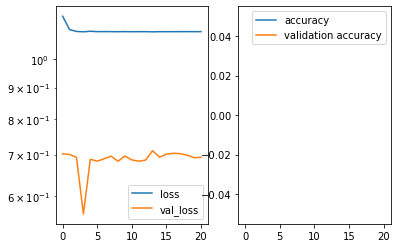

450/450 [==============================] - 389s 864ms/step - binary_accuracy: 0.4306 - loss: 1.1097 - val_binary_accuracy: 0.1983 - val_loss: 0.6933
Epoch 22/30
209/450 [============>.................] - ETA: 2:53 - binary_accuracy: 0.7386 - loss: 1.1028

In [ ]:
epochs = 30
history = model.fit(train_data, epochs=epochs,# shuffle=True,
            #  steps_per_epoch = train_data.n//train_data.batch_size,
              validation_data = val_data, 
           #   validation_steps = val_data.n//val_data.batch_size,
              class_weight=class_weights,
              callbacks=[plot_losses],
              verbose=1,
              max_queue_size=30,                # maximum size for the generator queue
              workers=16,                        # maximum number of processes to spin up when using process-based threading
              use_multiprocessing=False)

In [ ]:
1